In [1]:
%matplotlib inline


### Supervised Learning : Naive Bayes Classifier 

Welcome to the "Supervised Learning : Naive Bayes Classifier" practical session.  

Programming Language : Python 
Editor : Jupyter Notebook. 

Pandas : Data loading, processing, transformation and manipulation.
Scikit-learn : Example data source, ML and statistical analysis


In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

#### Load relevant data and partition the data for train and test
Here we will use the same breast cancer data set.
After loading the data we will partition the data into train and test. 
In this example we will 80% data for training and remaining 20% will be left for testing. 

In [29]:
# Load breast cancer data
dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(pd.DataFrame(X_train))
#print(y_train)

        0      1       2       3        4        5         6         7   \
0    17.99  20.66  117.80   991.7  0.10360  0.13040  0.120100  0.088240   
1    20.29  14.34  135.10  1297.0  0.10030  0.13280  0.198000  0.104300   
2     9.00  14.40   56.36   246.3  0.07005  0.03116  0.003681  0.003472   
3    12.21  14.09   78.78   462.0  0.08108  0.07823  0.068390  0.025340   
4    12.34  14.95   78.29   469.1  0.08682  0.04571  0.021090  0.020540   
..     ...    ...     ...     ...      ...      ...       ...       ...   
450  19.79  25.12  130.40  1192.0  0.10150  0.15890  0.254500  0.114900   
451  10.75  14.97   68.26   355.3  0.07793  0.05139  0.022510  0.007875   
452  17.20  24.52  114.20   929.4  0.10710  0.18300  0.169200  0.079440   
453  14.03  21.25   89.79   603.4  0.09070  0.06945  0.014620  0.018960   
454  13.03  18.42   82.61   523.8  0.08983  0.03766  0.025620  0.029230   

         8        9   ...      20     21      22      23       24       25  \
0    0.1992  0.06069 

## Hyper parameter tuning through grid search
The grid search process is employed to find the best hyperparameter for the Gaussian Naive Bayes model, specifically the 'var_smoothing' parameter.

- Define the hyperparameter grid: param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}. This line creates a dictionary where the key is the name of the hyperparameter we want to tune ('var_smoothing') and the value is an array of the values we want to test. In this case, we are generating 100 values evenly spaced on a log scale between 10^0 (1) and 10^-9.

- Define the model: gnb = GaussianNB(). This line initiates the Gaussian Naive Bayes classifier.

- Setup the grid search: gnb_cv = GridSearchCV(gnb, param_grid, cv=skf, scoring='accuracy'). This line initiates the GridSearchCV object which will be used to find the best hyperparameters for the model. It takes the model (gnb), the hyperparameter grid (param_grid), the cross-validation splitting strategy (skf, which is a StratifiedKFold object), and the scoring metric ('accuracy') as arguments.

- Fit the model to the data: gnb_cv.fit(X_train, y_train). This line starts the grid search. It will train the Gaussian Naive Bayes model with all different combinations of hyperparameters and perform cross-validation. It will then select the hyperparameters that yield the highest average accuracy across all folds.

- Print the best parameters: print("Best Parameters: " + str(gnb_cv.best_params_)). After the grid search is completed, this line prints the best 'var_smoothing' value that was found. We will use this best paramter to train our classifier. 

In [4]:
# Use stratified cross-validation
skf = StratifiedKFold(n_splits=5)

# Setting up hyperparameters
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Use Gaussian Naive Bayes model
gnb = GaussianNB()

# Use grid search for hyperparameters tuning
gnb_cv = GridSearchCV(gnb, param_grid, cv=skf, scoring='accuracy')

# Fit the model to the training data
gnb_cv.fit(X_train, y_train)

# Find out the best parameters
print("Best Parameters: " + str(gnb_cv.best_params_))

# Using the best estimator for predictions
gnb_best = gnb_cv.best_estimator_

Best Parameters: {'var_smoothing': 5.336699231206302e-09}


### Model Training and Performance Evaluation via five-fold cross validation.

- Define the cross-validation strategy: cv = StratifiedKFold(n_splits=5). This line initiates the StratifiedKFold object, which is a cross-validator that provides train/test indices to split the data into train/test sets. The 'Stratified' part means that the folds are made by preserving the percentage of samples for each class.

- Initialize necessary lists and parameters: tprs = [], aucs = [], mean_fpr = np.linspace(0, 1, 100). These lines set up the necessary lists and parameters to store true positive rates (TPR), area under curve (AUC) scores, and the mean false positive rate (FPR).

- Iterate over each fold: for i, (train, val) in enumerate(cv.split(X_train, y_train)). This loop goes through each of the five splits of the data. For each split, it fits the model on the training data (gnb_best.fit(X_train[train], y_train[train])) and generates a ROC curve (viz = metrics.plot_roc_curve(gnb_best, X_train[val], y_train[val]...). The TPR for each FPR is interpolated and stored, as is the AUC.

- Plot a baseline ROC curve: ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8). This line plots a diagonal line that represents a random classifier. This serves as a baseline to compare the Naive Bayes classifier against.

- Calculate mean TPR and AUC: mean_tpr = np.mean(tprs, axis=0), mean_auc = auc(mean_fpr, mean_tpr). These lines calculate the mean T

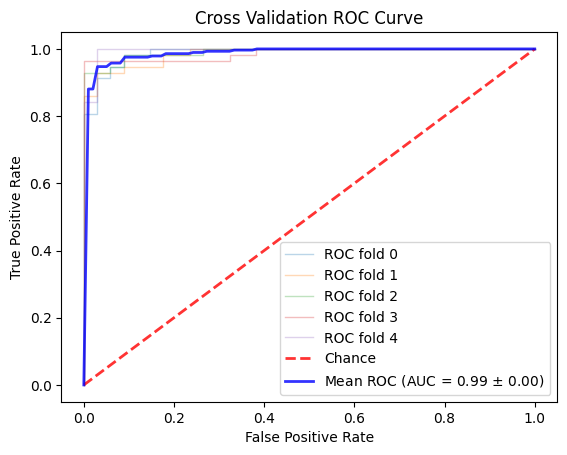

In [30]:
# ROC curve for each fold in cross validation
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, val) in enumerate(cv.split(X_train, y_train)):
    gnb_best.fit(X_train[train], y_train[train])
    y_score = gnb_best.predict_proba(X_train[val])[:, 1]
    fpr, tpr, _ = roc_curve(y_train[val], y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, alpha=0.3, lw=1, name='ROC fold {}'.format(i))
    interp_tpr = np.interp(mean_fpr, roc_display.fpr, roc_display.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc(fpr, tpr))
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

plt.title("Cross Validation ROC Curve")
plt.legend(loc='best')
plt.show()

### Finally, we evaluate the performance of our trained model on the left out test dataset. 

In [31]:
print(y_test)

[1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0
 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0
 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 1 1]


In [32]:
# Predicting the target for test dataset
y_pred_test = gnb_best.predict(X_test)
print(y_pred_test)

[0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0
 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 1 1]


Test Data Accuracy: 0.9210526315789473


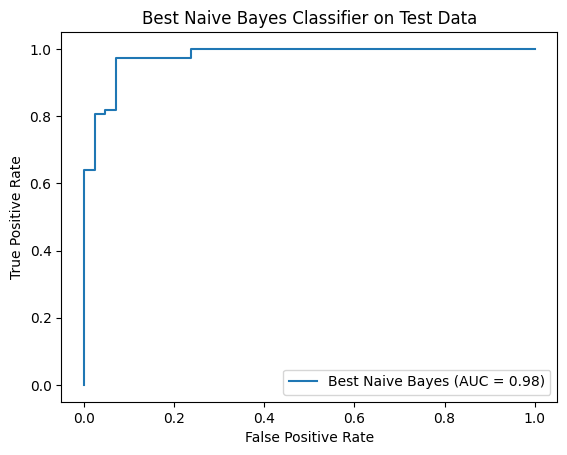

In [34]:
# Computing the accuracy for test data
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
print("Test Data Accuracy: " + str(accuracy_test))

#print(gnb_best.predict_proba(X_test))

# ROC curve for test data
y_test_score = gnb_best.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_score)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Best Naive Bayes')
display.plot()
plt.title("Best Naive Bayes Classifier on Test Data")
plt.show()


### Your Task

1. Create a train test split using 50% data for training and 50% for testing. 
2. Run a 10 fold cross validation   [ You can use the same grid search CV and cross validation code.]
3. What is the accuracy of the newly trained classifier ?